# **Section 1: Data Retrieval and Preprocessing (15 Marks)**

In [ ]:
# Install and load necessary packages
if (!require(quantmod)) install.packages("quantmod")
if (!require(ggplot2)) install.packages("ggplot2")
if (!require(forecast)) install.packages("forecast")
if (!require(tseries)) install.packages("tseries")
if (!require(moments)) install.packages("moments")  # For skewness and kurtosis

library(quantmod)
library(ggplot2)
library(forecast)
library(tseries)
library(moments)

In [ ]:
# Data Retrieval: Download S&P 500 data from Yahoo Finance
getSymbols("^GSPC", src = "yahoo", from = "2000-01-01", to = "2023-12-31")
sp500_prices <- Ad(GSPC)

[1] "GSPC"

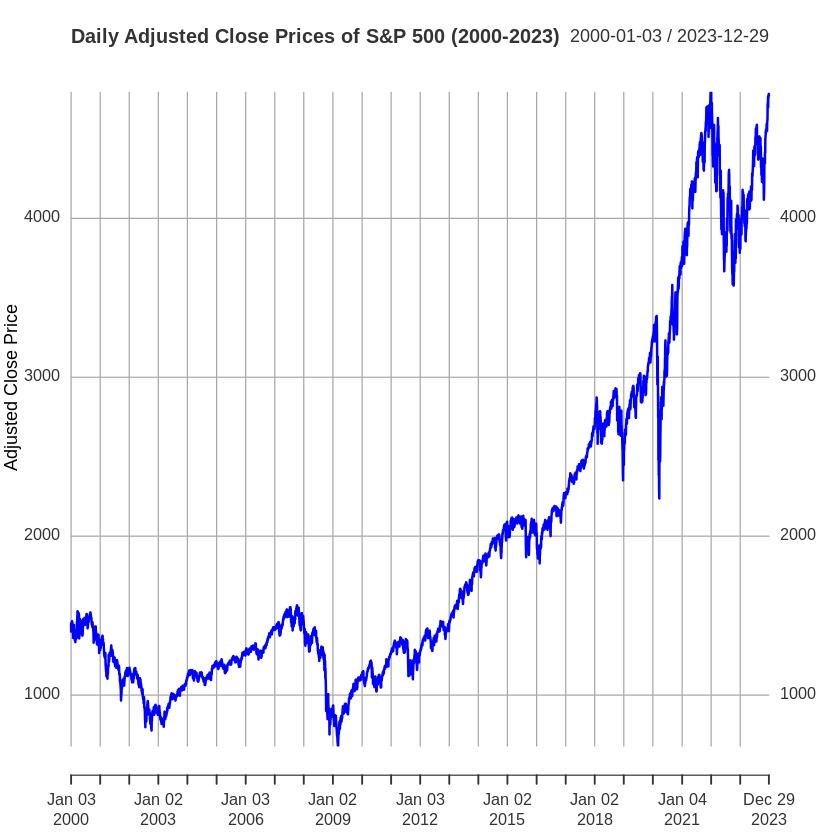

In [ ]:
# Plot Daily Adjusted Close Prices
plot(sp500_prices, main = "Daily Adjusted Close Prices of S&P 500 (2000-2023)",
     xlab = "Date", ylab = "Adjusted Close Price", col = "blue")

In [ ]:
# Summary Statistics
summary(sp500_prices)


     Index            GSPC.Adjusted   
 Min.   :2000-01-03   Min.   : 676.5  
 1st Qu.:2006-01-04   1st Qu.:1191.4  
 Median :2011-12-30   Median :1457.3  
 Mean   :2012-01-02   Mean   :1973.6  
 3rd Qu.:2017-12-29   3rd Qu.:2584.8  
 Max.   :2023-12-29   Max.   :4796.6  

In [ ]:
# Calculate Daily Returns
sp500_daily_returns <- dailyReturn(sp500_prices)

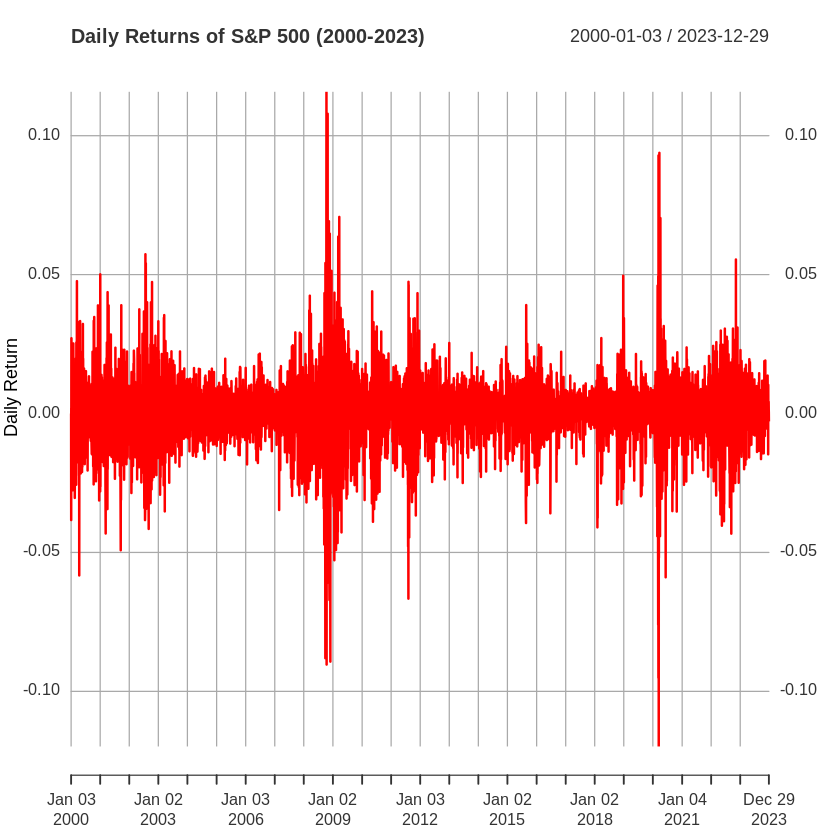

In [ ]:
# Plot Daily Returns to Visualize Variability
plot(sp500_daily_returns, main = "Daily Returns of S&P 500 (2000-2023)",
     xlab = "Date", ylab = "Daily Return", col = "red")


In [ ]:
# Check for Missing Values
cat("Number of Missing Values: ", sum(is.na(sp500_prices)), "\n")


Number of Missing Values:  0 


In [ ]:
# Apply Log Transformation to Stabilize Variance
log_sp500_prices <- log(sp500_prices)

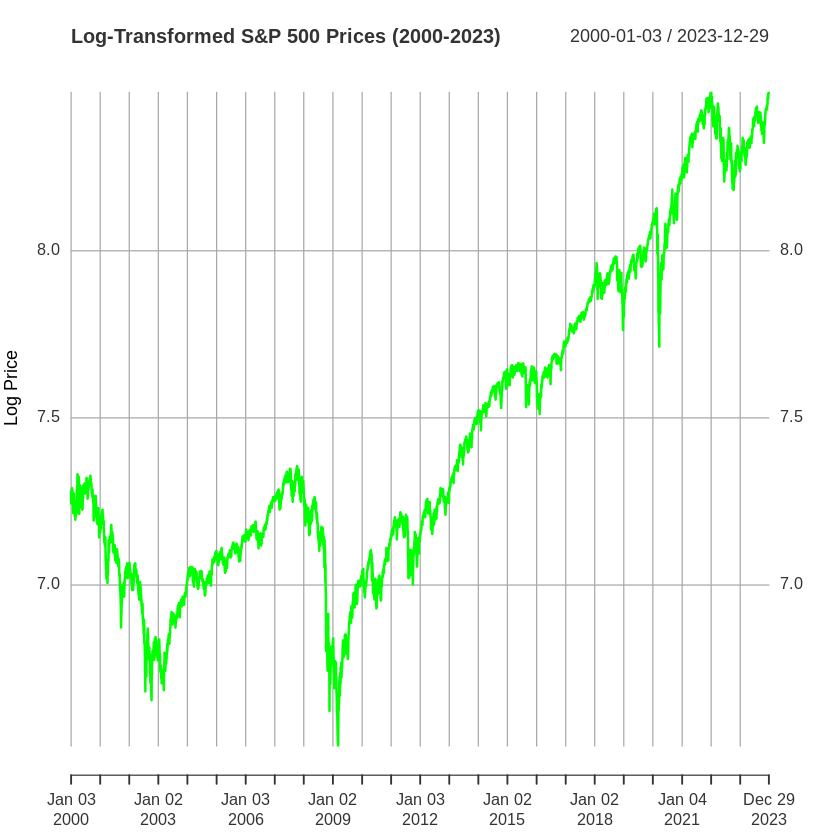

In [ ]:
# Plot Log-Transformed Series
plot(log_sp500_prices, main = "Log-Transformed S&P 500 Prices (2000-2023)",
     xlab = "Date", ylab = "Log Price", col = "green")

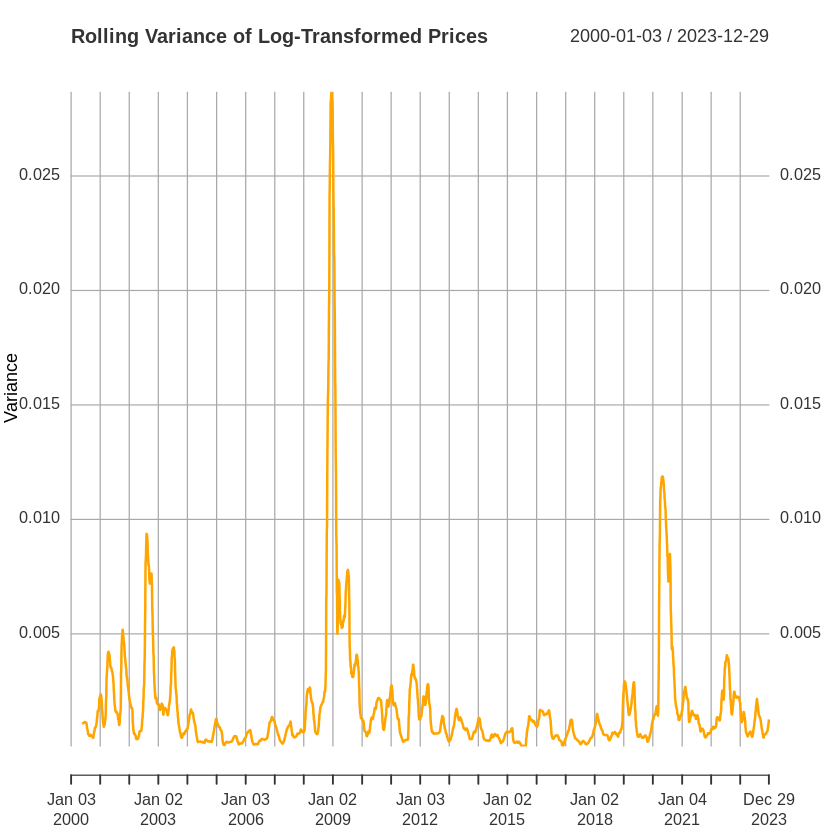

In [ ]:
# Verify Variance Stabilization After Log Transformation (using rolling variance)
roll_var <- rollapply(log_sp500_prices, width = 100, FUN = var, by = 1, fill = NA)
plot(roll_var, main = "Rolling Variance of Log-Transformed Prices",
     xlab = "Date", ylab = "Variance", col = "orange")

**Section 2: Preliminary Analysis and Model Identification (20 Marks)**


	Augmented Dickey-Fuller Test

data:  log_sp500_prices
Dickey-Fuller = -2.355, Lag order = 18, p-value = 0.428
alternative hypothesis: stationary



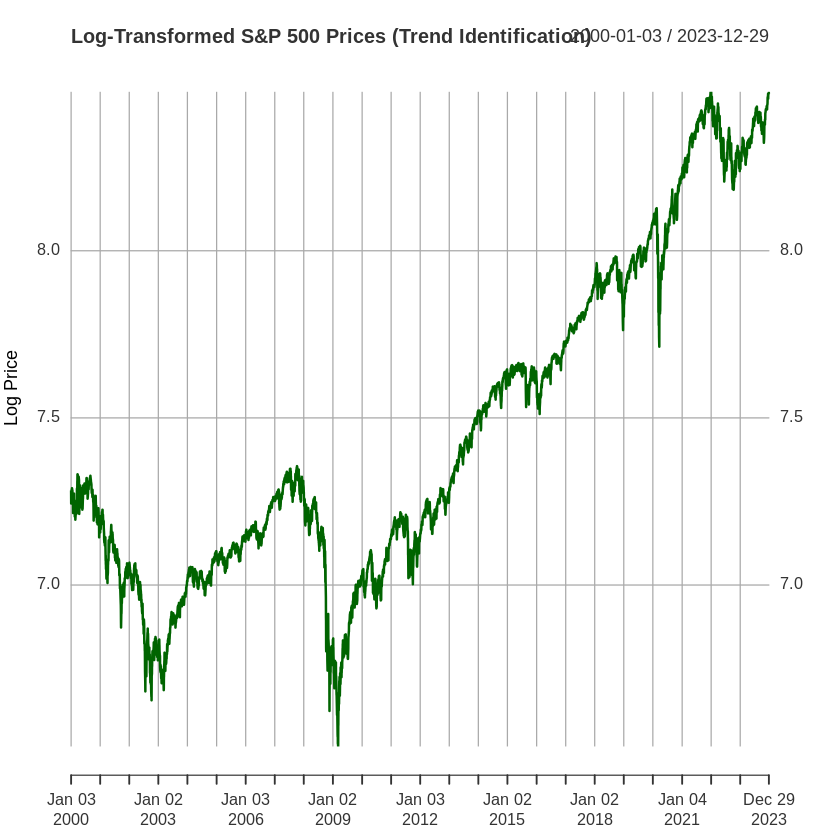

In [ ]:
# Perform Augmented Dickey-Fuller (ADF) Test on Log-Transformed Data
adf_test_result <- adf.test(log_sp500_prices)
print(adf_test_result)

# Plot Log Series for Visual Inspection (identifying trend/seasonality)
plot(log_sp500_prices, main = "Log-Transformed S&P 500 Prices (Trend Identification)",
     xlab = "Date", ylab = "Log Price", col = "darkgreen")

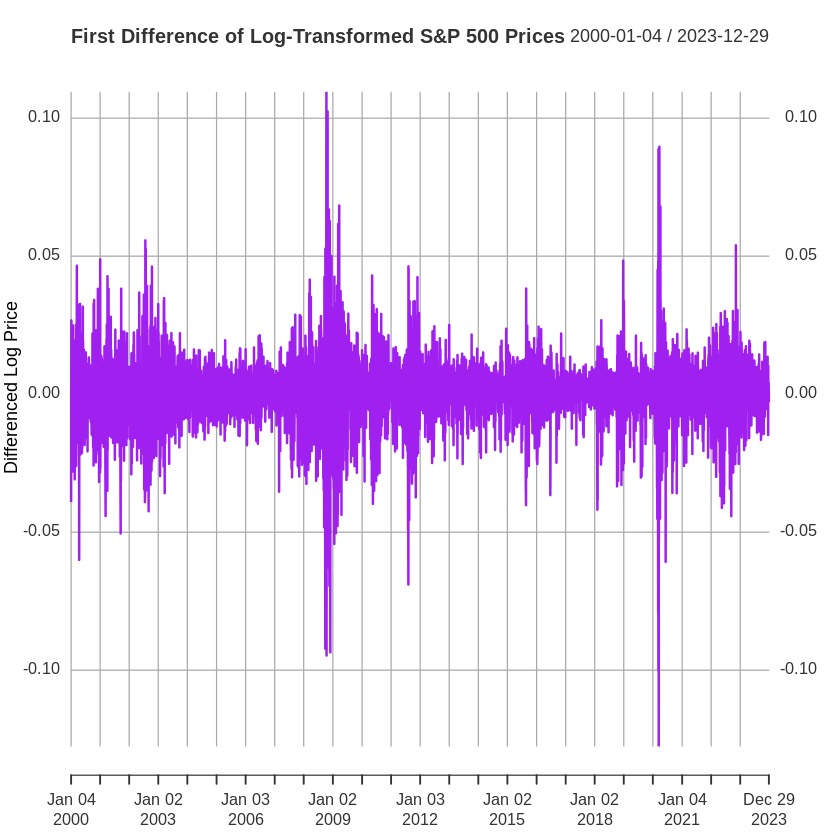

In [ ]:
# Apply First Differencing to Make Series Stationary
diff_log_sp500_prices <- diff(log_sp500_prices, differences = 1)
diff_log_sp500_prices <- na.omit(diff_log_sp500_prices)

# Plot Differenced Series
plot(diff_log_sp500_prices, main = "First Difference of Log-Transformed S&P 500 Prices",
     xlab = "Date", ylab = "Differenced Log Price", col = "purple")


In [ ]:
# Re-run ADF Test to Verify Stationarity
adf_test_diff_result <- adf.test(diff_log_sp500_prices)
print(adf_test_diff_result)

Warning message in adf.test(diff_log_sp500_prices):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_sp500_prices
Dickey-Fuller = -18.453, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary



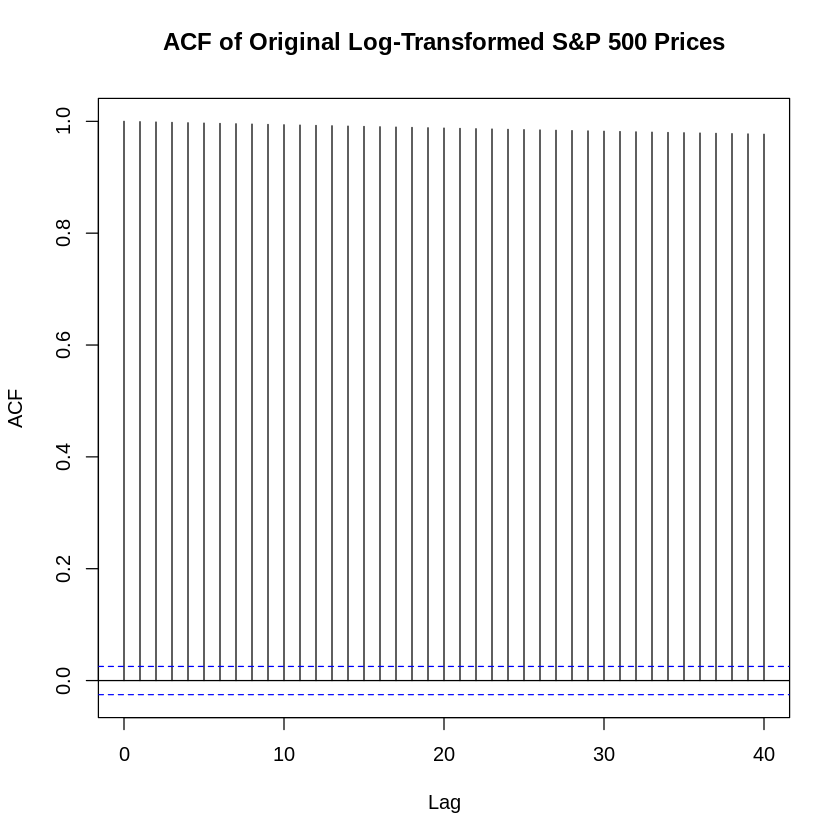

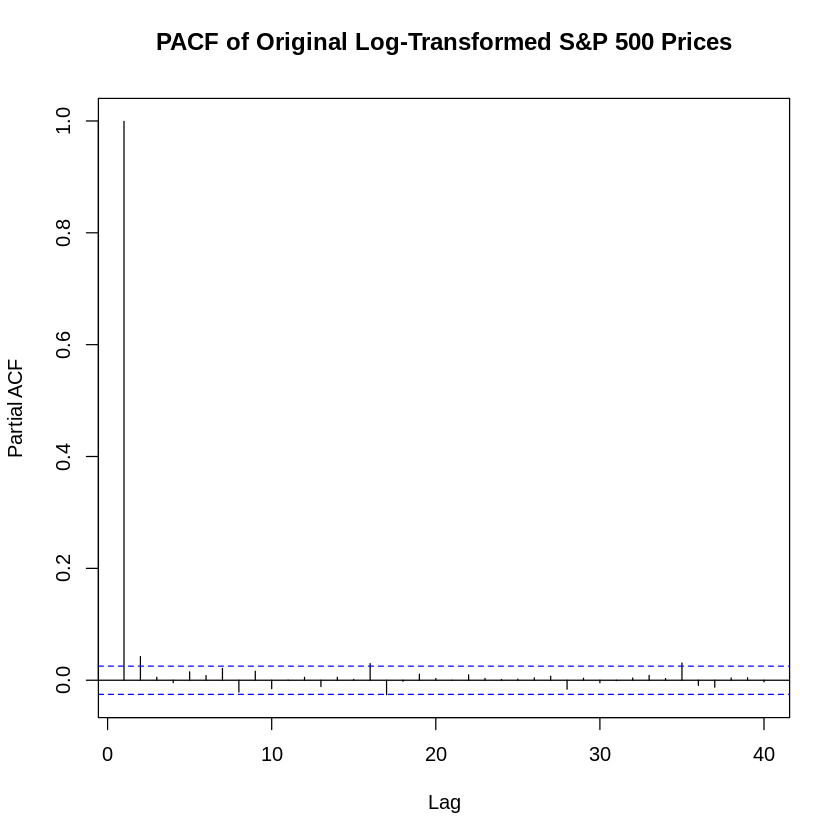

In [ ]:
# Plot ACF and PACF of Original Log-Transformed Series for Model Identification
acf(log_sp500_prices, main = "ACF of Original Log-Transformed S&P 500 Prices", lag.max = 40)
pacf(log_sp500_prices, main = "PACF of Original Log-Transformed S&P 500 Prices", lag.max = 40)


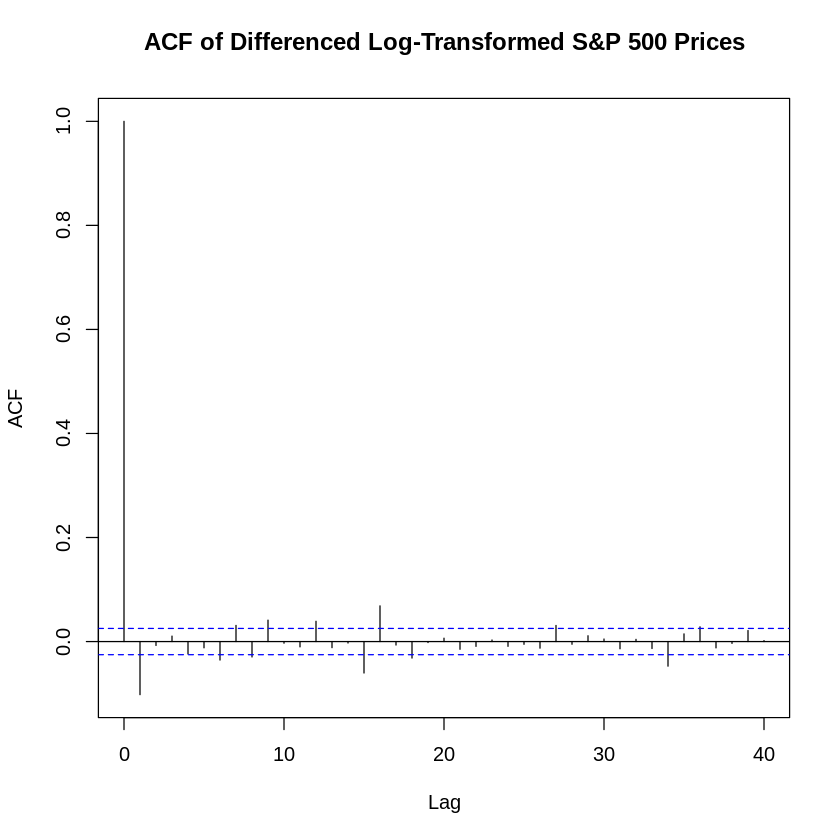

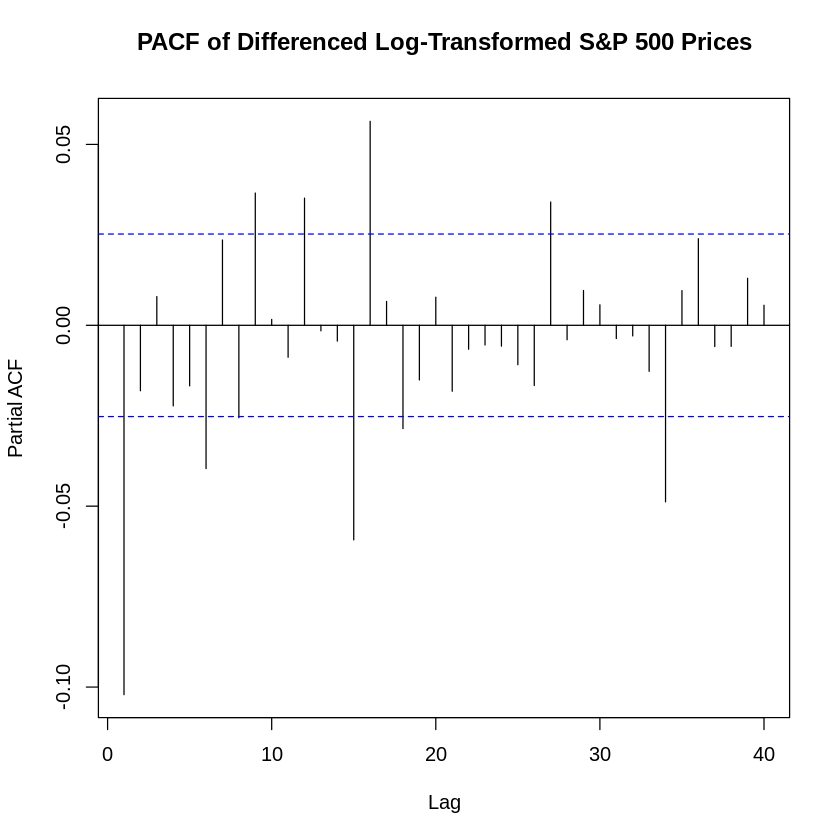

In [ ]:
# Plot ACF and PACF of Differenced Series for Model Identification
acf(diff_log_sp500_prices, main = "ACF of Differenced Log-Transformed S&P 500 Prices", lag.max = 40)
pacf(diff_log_sp500_prices, main = "PACF of Differenced Log-Transformed S&P 500 Prices", lag.max = 40)


Ljung-Box Test Before Differencing:

	Box-Ljung test

data:  residuals_before
X-squared = 90.118, df = 20, p-value = 7.068e-11


Ljung-Box Test After First Differencing:

	Box-Ljung test

data:  residuals_after
X-squared = 90.087, df = 20, p-value = 7.156e-11



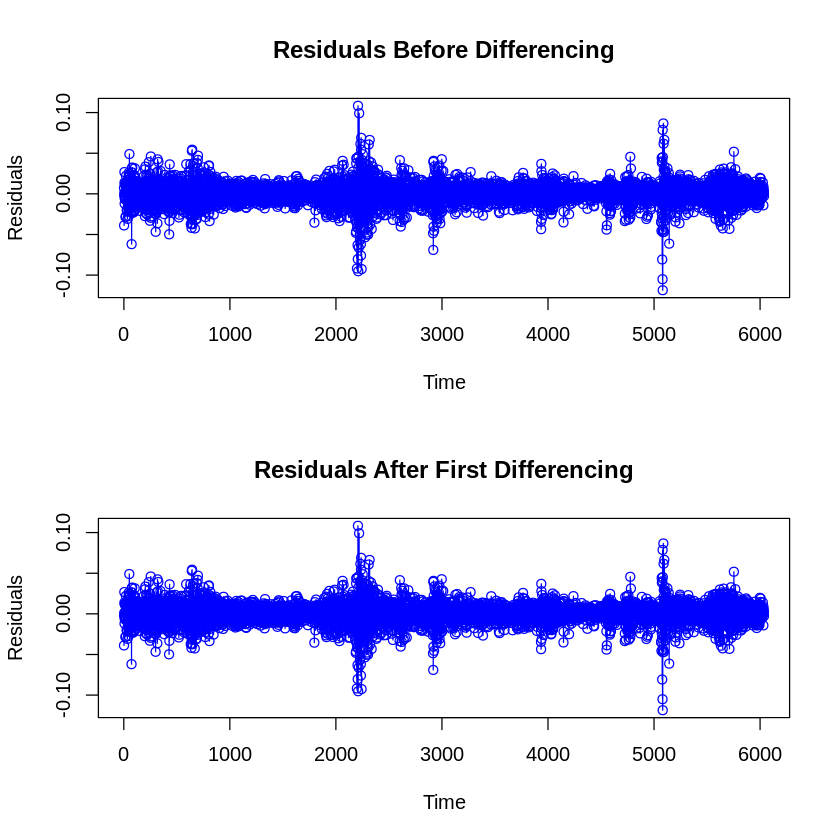

In [ ]:
# Step 1: Plot residuals of the log-transformed series (before differencing)
par(mfrow = c(2, 1)) # Setting up 2 rows for plots
plot(residuals(auto.arima(log_sp500_prices, seasonal = FALSE)),
     main = "Residuals Before Differencing",
     ylab = "Residuals", xlab = "Time", col = "blue", type = "o")

# Step 2: Apply first differencing to the series
diff_log_sp500_prices <- diff(log_sp500_prices, differences = 1)

# Step 3: Plot residuals of the differenced series (after differencing)
plot(residuals(auto.arima(diff_log_sp500_prices, seasonal = FALSE)),
     main = "Residuals After First Differencing",
     ylab = "Residuals", xlab = "Time", col = "blue", type = "o")

# Step 4: Perform Ljung-Box test on residuals before and after differencing

# Residuals before differencing
residuals_before <- residuals(auto.arima(log_sp500_prices, seasonal = FALSE))
ljung_box_before <- Box.test(residuals_before, lag = 20, type = "Ljung-Box")
cat("\nLjung-Box Test Before Differencing:\n")
print(ljung_box_before)

# Residuals after first differencing
residuals_after <- residuals(auto.arima(diff_log_sp500_prices, seasonal = FALSE))
ljung_box_after <- Box.test(residuals_after, lag = 20, type = "Ljung-Box")
cat("\nLjung-Box Test After First Differencing:\n")
print(ljung_box_after)

# Reset plot layout to default
par(mfrow = c(1, 1))

**Section 3: ARIMA Model Fitting and Comparison (30 Marks)**

In [ ]:
# Automatically Select the Best ARIMA Model Using auto.arima
auto_arima_model <- auto.arima(log_sp500_prices, seasonal = FALSE)

# Print Summary of the Automatically Selected Model
cat("Summary of auto.arima selected model:\n")
summary(auto_arima_model)

# Store AIC and BIC of the Auto ARIMA Model
auto_aic <- AIC(auto_arima_model)
auto_bic <- BIC(auto_arima_model)

Summary of auto.arima selected model:


Series: log_sp500_prices 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.1020
s.e.   0.0128

sigma^2 = 0.0001517:  log likelihood = 17974.84
AIC=-35945.68   AICc=-35945.68   BIC=-35932.27

Training set error measures:
                       ME       RMSE         MAE         MPE     MAPE      MASE
Training set 0.0002179855 0.01231506 0.008185368 0.002617216 0.111152 0.9996539
                     ACF1
Training set -0.002284435

In [ ]:
# Manually Refine the Model by Looping Through p and q Values Around the Suggested Model
best_aic <- Inf
best_model <- NULL
best_order <- c(0, 1, 0)

# Manually Iterate Through AR (p) and MA (q) Orders, Fixing Differencing (d) to 1
for (p in 0:3) {
  for (q in 0:3) {
    try({
      # Fit the ARIMA Model with Different Combinations of p, d, q
      model <- Arima(log_sp500_prices, order = c(p, 1, q))
      model_aic <- AIC(model)

      # Print Model Order and AIC for Tracking
      cat("ARIMA(", p, ",1,", q, ") AIC:", model_aic, "\n")

      # Update the Best Model if Current Model Has Lower AIC
      if (model_aic < best_aic) {
        best_aic <- model_aic
        best_model <- model
        best_order <- c(p, 1, q)
      }
    }, silent = TRUE)
  }
}

# Print the Best Manual ARIMA Model Found
cat("\nBest Manual ARIMA Model: ARIMA(", best_order[1], ",", best_order[2], ",", best_order[3], ") with AIC:", best_aic, "\n")
summary(best_model)

# Store AIC and BIC of the Best Manual Model
manual_aic <- AIC(best_model)
manual_bic <- BIC(best_model)


ARIMA( 0 ,1, 0 ) AIC: -35884.69 
ARIMA( 0 ,1, 1 ) AIC: -35947.2 
ARIMA( 0 ,1, 2 ) AIC: -35945.42 
ARIMA( 0 ,1, 3 ) AIC: -35943.59 
ARIMA( 1 ,1, 0 ) AIC: -35945.68 
ARIMA( 1 ,1, 1 ) AIC: -35945.37 
ARIMA( 1 ,1, 2 ) AIC: -35943.45 
ARIMA( 1 ,1, 3 ) AIC: -35941.69 
ARIMA( 2 ,1, 0 ) AIC: -35945.59 
ARIMA( 2 ,1, 1 ) AIC: -35943.51 
ARIMA( 2 ,1, 2 ) AIC: -35941.73 
ARIMA( 2 ,1, 3 ) AIC: -35939.69 
ARIMA( 3 ,1, 0 ) AIC: -35944 
ARIMA( 3 ,1, 1 ) AIC: -35941.89 
ARIMA( 3 ,1, 2 ) AIC: -35939.92 
ARIMA( 3 ,1, 3 ) AIC: -35946.04 

Best Manual ARIMA Model: ARIMA( 0 , 1 , 1 ) with AIC: -35947.2 


Series: log_sp500_prices 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.1043
s.e.   0.0129

sigma^2 = 0.0001517:  log likelihood = 17975.6
AIC=-35947.2   AICc=-35947.2   BIC=-35933.79

Training set error measures:
                     ME       RMSE         MAE         MPE      MAPE      MASE
Training set 0.00022086 0.01231351 0.008187173 0.002652148 0.1111747 0.9998743
                     ACF1
Training set 0.0001370121

In [ ]:
# Compare AIC and BIC of auto.arima and Manually Selected Models
cat("\nModel Comparison Summary:\n")
cat("Auto ARIMA Model: AIC =", auto_aic, ", BIC =", auto_bic, "\n")
cat("Manual ARIMA Model: AIC =", manual_aic, ", BIC =", manual_bic, "\n")

# Choose the Final Model Based on AIC and BIC
if (manual_aic < auto_aic && manual_bic < auto_bic) {
  cat("\nThe manually refined ARIMA(", best_order[1], ",", best_order[2], ",", best_order[3], ") is preferred based on lower AIC and BIC.\n")
  final_model <- best_model
  final_model_name <- paste("ARIMA(", best_order[1], ",", best_order[2], ",", best_order[3], ")")
} else {
  cat("\nThe auto-selected ARIMA model is preferred based on AIC and BIC.\n")
  final_model <- auto_arima_model
  final_model_name <- "auto.arima() selected model"
}



Model Comparison Summary:
Auto ARIMA Model: AIC = -35945.68 , BIC = -35932.27 
Manual ARIMA Model: AIC = -35947.2 , BIC = -35933.79 

The manually refined ARIMA( 0 , 1 , 1 ) is preferred based on lower AIC and BIC.


**Section 4: Residual Diagnostics and Assumption Validation (20 Marks)**

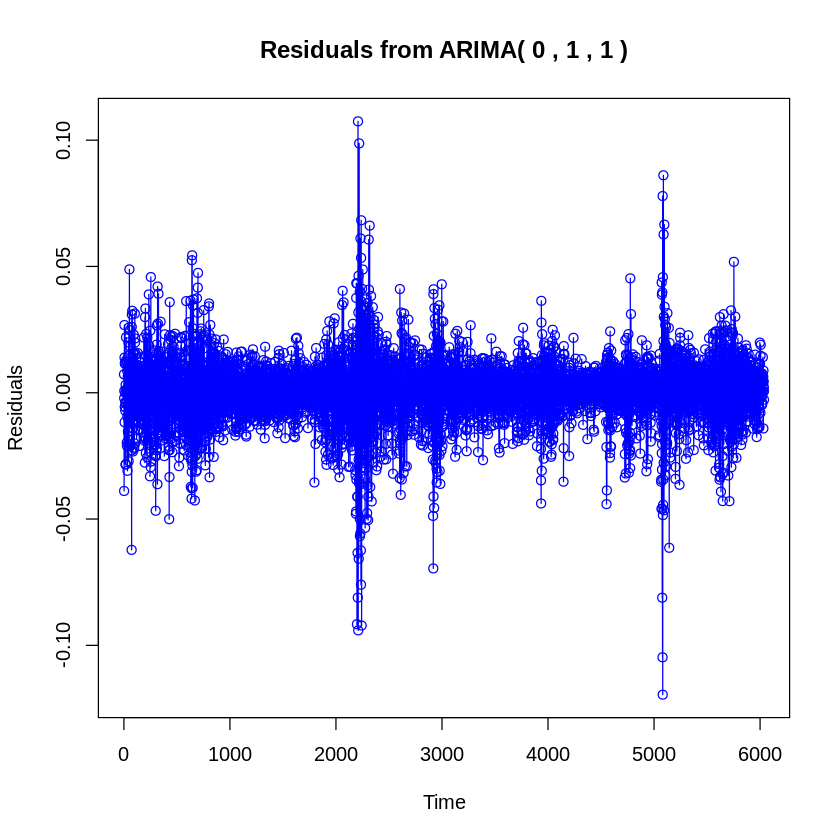

In [ ]:
# Plot Residuals from Final ARIMA Model
plot(residuals(final_model), main = paste("Residuals from", final_model_name),
     xlab = "Time", ylab = "Residuals", col = "blue", type = "o")



	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 29.721, df = 9, p-value = 0.0004893

Model df: 1.   Total lags used: 10



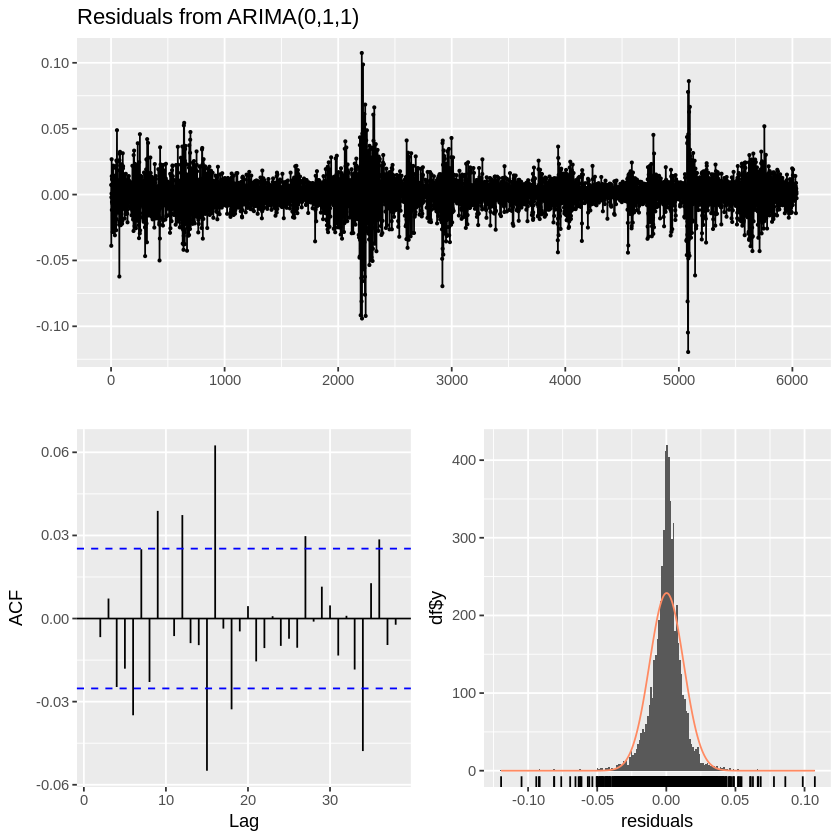

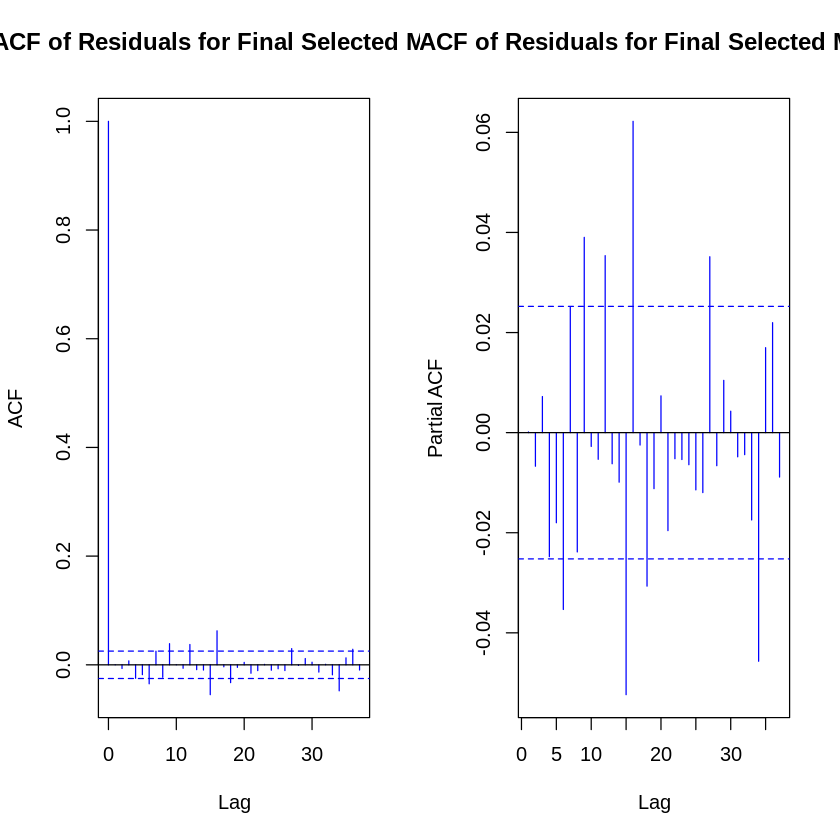

In [ ]:
# Detailed Residual Diagnostics for the Selected Final Model
# Using "checkresiduals" for comprehensive residual diagnostics
checkresiduals(final_model, main = paste("Residuals of Final Model:", final_model_name))

# Diagnostic Plots for Residuals
# Plotting ACF and PACF
par(mfrow = c(1, 2))  # Setting up plotting layout to show two plots side by side

# Plotting the ACF of the residuals
acf(residuals(final_model), main = "ACF of Residuals for Final Selected Model", col = "blue")

# Plotting the PACF of the residuals
pacf(residuals(final_model), main = "PACF of Residuals for Final Selected Model", col = "blue")

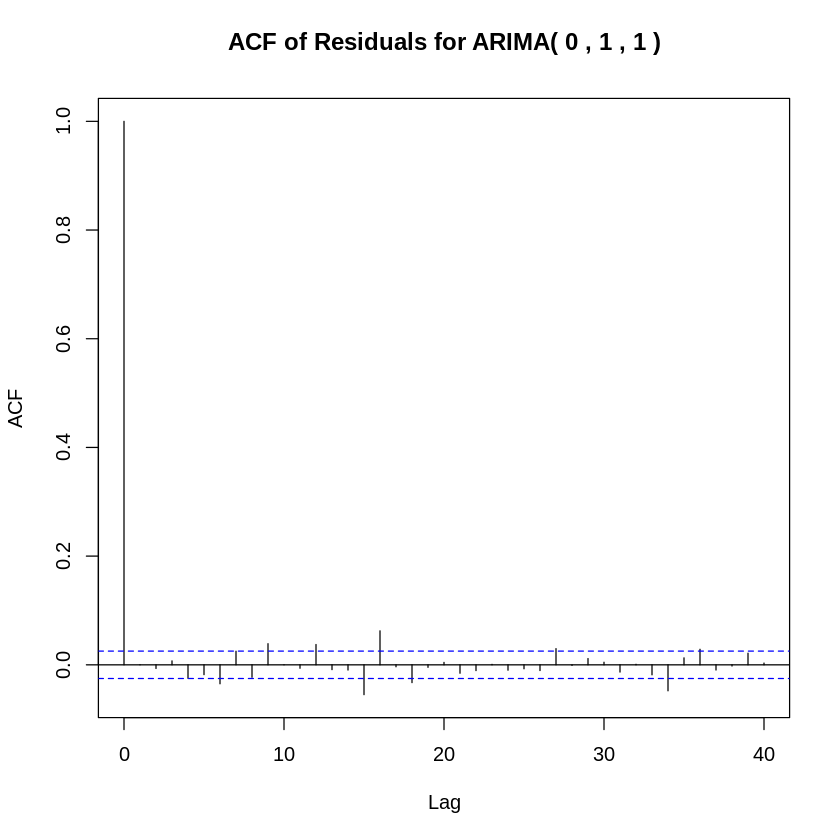

In [ ]:
# Plot ACF of Residuals for Independence Check
acf(residuals(final_model), main = paste("ACF of Residuals for", final_model_name), lag.max = 40)

In [ ]:
# Ljung-Box Test for Residual Independence
ljung_box_test <- Box.test(residuals(final_model), lag = 20, type = "Ljung-Box")
cat("\nLjung-Box Test for Independence of Residuals:\n")
print(ljung_box_test)


Ljung-Box Test for Independence of Residuals:

	Box-Ljung test

data:  residuals(final_model)
X-squared = 88.194, df = 20, p-value = 1.531e-10



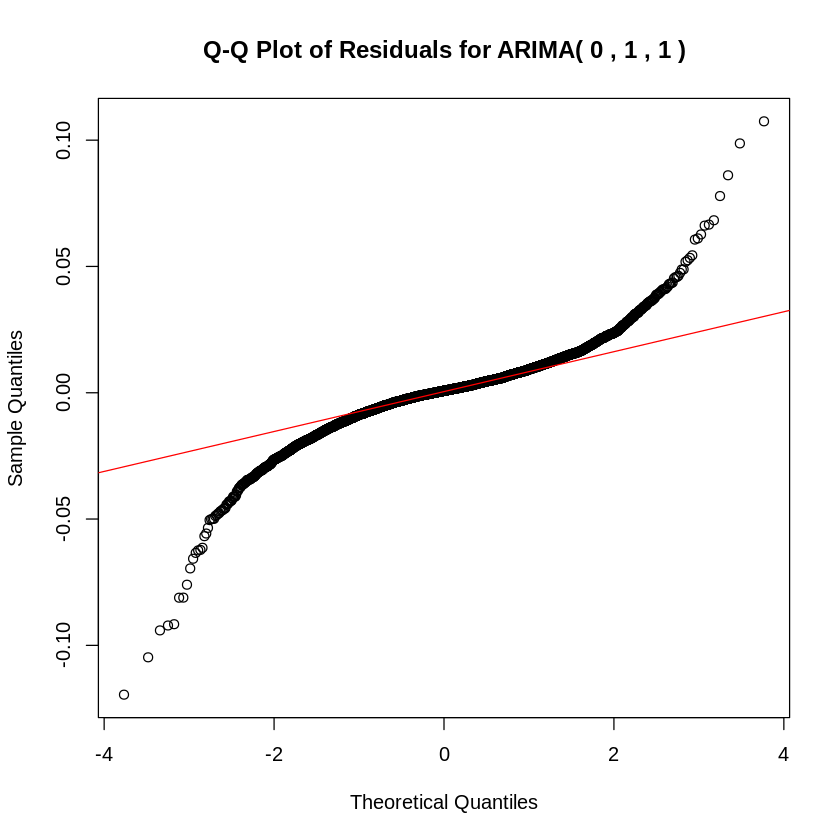

In [ ]:
# Q-Q Plot for Normality Check of Residuals
qqnorm(residuals(final_model), main = paste("Q-Q Plot of Residuals for", final_model_name))
qqline(residuals(final_model), col = "red")

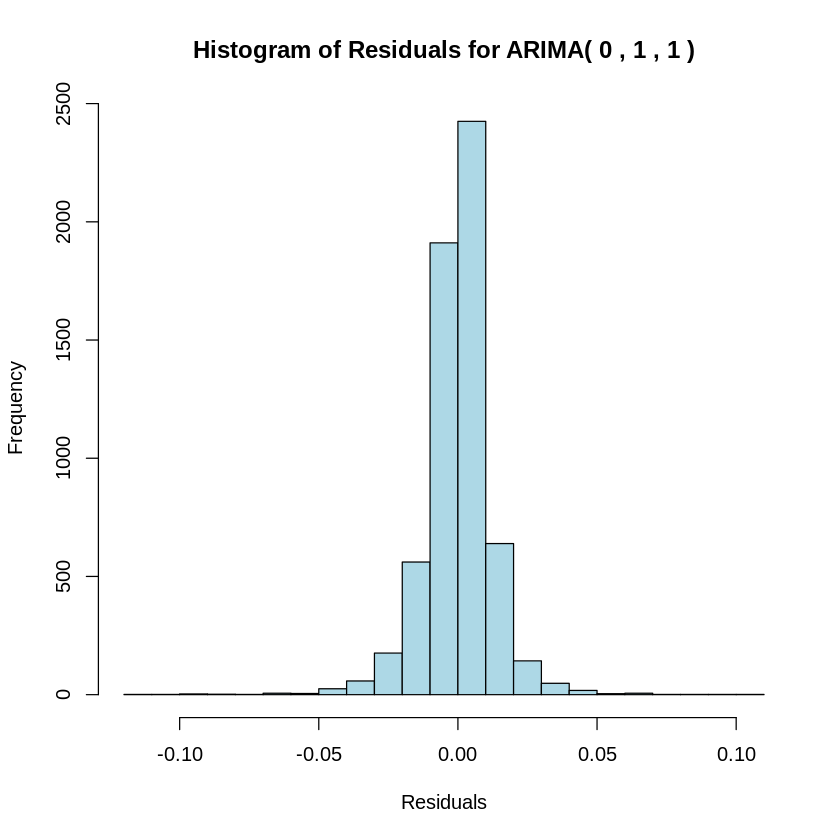

In [ ]:
# Histogram of Residuals
hist(residuals(final_model), breaks = 30, main = paste("Histogram of Residuals for", final_model_name),
     xlab = "Residuals", col = "lightblue")

In [ ]:
# Calculate Skewness and Kurtosis of Residuals
residual_skewness <- skewness(residuals(final_model))
residual_kurtosis <- kurtosis(residuals(final_model))

cat("Skewness of Residuals: ", residual_skewness, "\n")
cat("Kurtosis of Residuals: ", residual_kurtosis, "\n")

Skewness of Residuals:  -0.5007769 
Kurtosis of Residuals:  12.70026 


**Section 5: Model Evaluation and Performance Comparison (15 Marks)**

In [ ]:
# Split the Data into Training and Validation Sets
split_date <- "2022-12-31"
training_data <- window(log_sp500_prices, end = as.Date(split_date))
validation_data <- window(log_sp500_prices, start = as.Date("2023-01-01"))

In [ ]:
# Refit the Final Model on Training Data
final_model_train <- Arima(training_data, order = best_order)

In [ ]:
# Refit the Final Model on Training Data
final_model_train <- Arima(training_data, order = best_order)

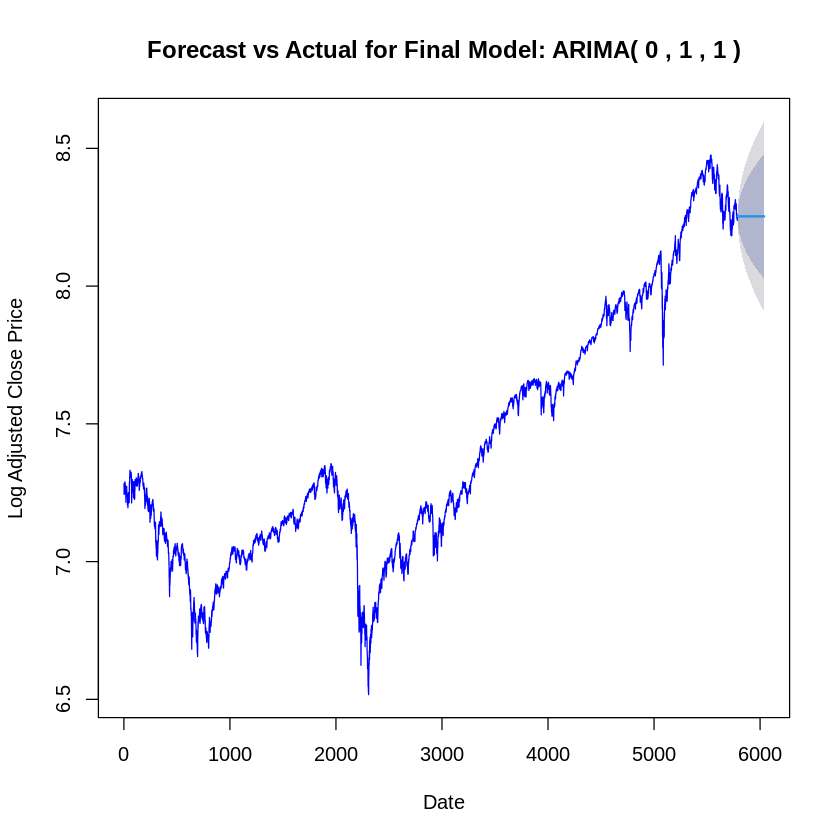

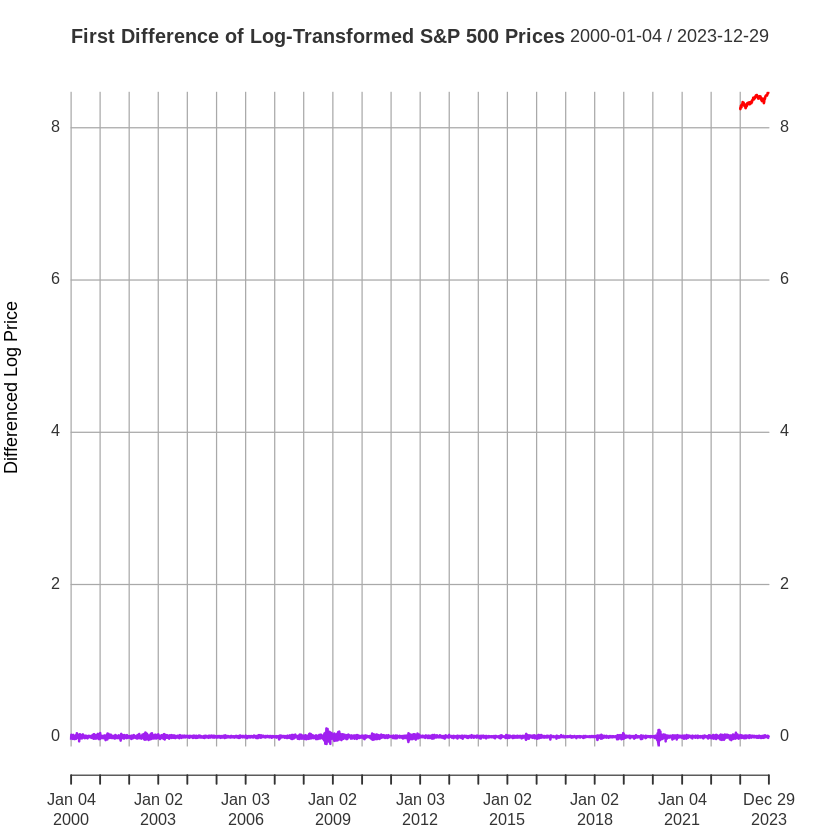

In [ ]:
# Forecast for Validation Period
forecast_horizon <- length(validation_data)
forecast_result <- forecast(final_model_train, h = forecast_horizon)

# Plot the Forecasted vs Actual Validation Data
plot(forecast_result, main = paste("Forecast vs Actual for Final Model:", final_model_name),
     xlab = "Date", ylab = "Log Adjusted Close Price", col = "blue")
lines(validation_data, col = "red", lwd = 2)  # Actual values in red for comparison
legend("topleft", legend = c("Forecast", "Actual"), col = c("blue", "red"), lty = 1)


In [ ]:
# Calculate Accuracy Metrics for Validation Set
accuracy_metrics <- accuracy(forecast_result, validation_data)
cat("\nAccuracy Metrics for Validation Set:\n")
print(accuracy_metrics)


Accuracy Metrics for Validation Set:
                      ME       RMSE         MAE         MPE      MAPE
Training set 0.000189074 0.01245636 0.008256759 0.002274979 0.1125774
Test set     0.107952885 0.12056090 0.108052075 1.287057524 1.2882604
                   MASE         ACF1
Training set  0.9993072 0.0002036336
Test set     13.0774330           NA


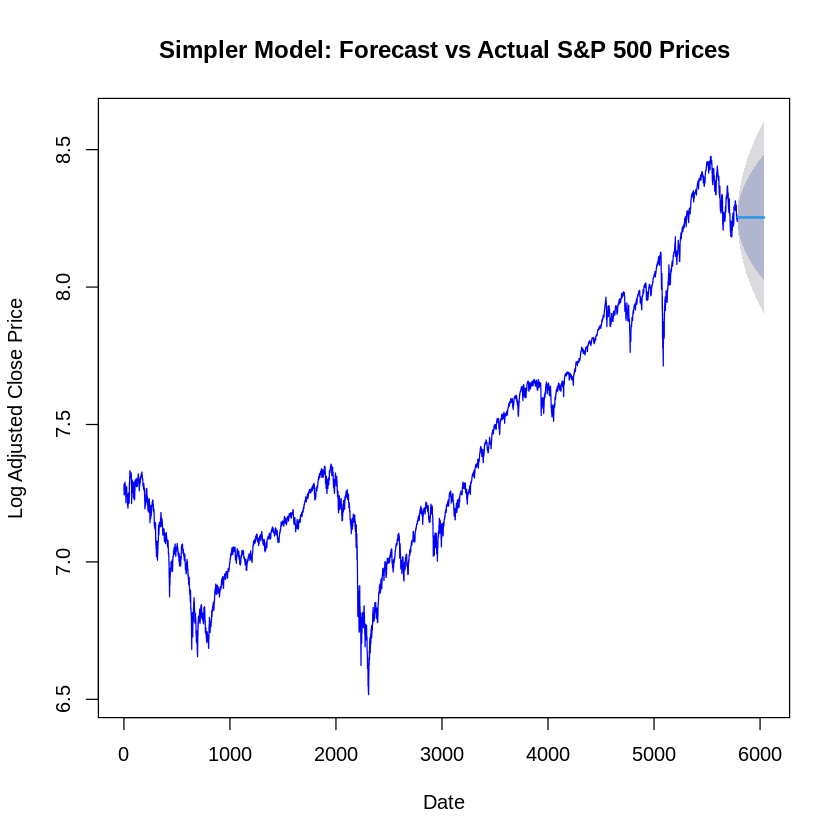

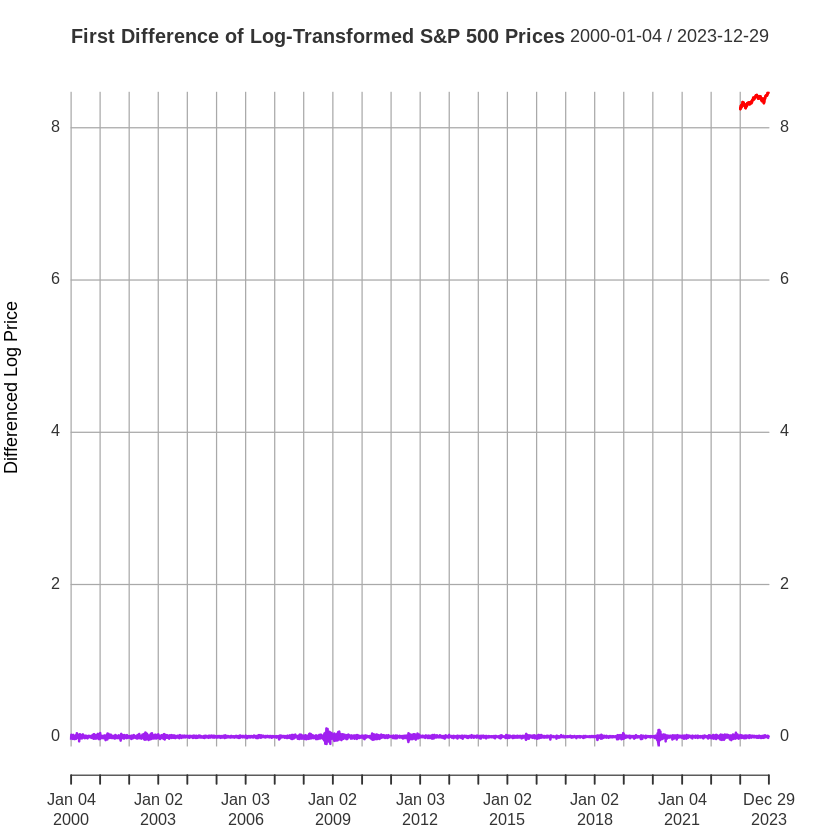

In [ ]:
# Fit a Simpler ARIMA Model Using auto.arima() with Reduced Parameters
simpler_model <- auto.arima(log_sp500_prices, max.p = 1, max.q = 1, seasonal = FALSE)

# Refit the Simpler Model on the Training Data
simpler_model_train <- Arima(training_data, order = arimaorder(simpler_model))
simpler_forecast_result <- forecast(simpler_model_train, h = forecast_horizon)

# Plot the Simpler Model Forecast vs Actual Validation Data
plot(simpler_forecast_result, main = "Simpler Model: Forecast vs Actual S&P 500 Prices",
     xlab = "Date", ylab = "Log Adjusted Close Price", col = "blue")
lines(validation_data, col = "red", lwd = 2)
legend("topleft", legend = c("Forecast (Simpler)", "Actual"), col = c("blue", "red"), lty = 1)


In [ ]:
# Calculate Accuracy Metrics for Simpler Model on Validation Set
simpler_accuracy_metrics <- accuracy(simpler_forecast_result, validation_data)
cat("\nAccuracy Metrics for Simpler Model on Validation Set:\n")
print(simpler_accuracy_metrics)


Accuracy Metrics for Simpler Model on Validation Set:
                       ME      RMSE         MAE         MPE      MAPE
Training set 0.0001865336 0.0124580 0.008255082 0.002243959 0.1125562
Test set     0.1078010611 0.1204251 0.107902883 1.285241610 1.2864764
                   MASE         ACF1
Training set  0.9991042 -0.002266465
Test set     13.0593765           NA


In [ ]:
# Compare Accuracy Metrics Between Final and Simpler Model
cat("\nComparison of Accuracy Metrics Between Final Model and Simpler Model:\n")
cat("Final Model Metrics:\n")
print(accuracy_metrics)
cat("Simpler Model Metrics:\n")
print(simpler_accuracy_metrics)



Comparison of Accuracy Metrics Between Final Model and Simpler Model:
Final Model Metrics:
                      ME       RMSE         MAE         MPE      MAPE
Training set 0.000189074 0.01245636 0.008256759 0.002274979 0.1125774
Test set     0.107952885 0.12056090 0.108052075 1.287057524 1.2882604
                   MASE         ACF1
Training set  0.9993072 0.0002036336
Test set     13.0774330           NA
Simpler Model Metrics:
                       ME      RMSE         MAE         MPE      MAPE
Training set 0.0001865336 0.0124580 0.008255082 0.002243959 0.1125562
Test set     0.1078010611 0.1204251 0.107902883 1.285241610 1.2864764
                   MASE         ACF1
Training set  0.9991042 -0.002266465
Test set     13.0593765           NA


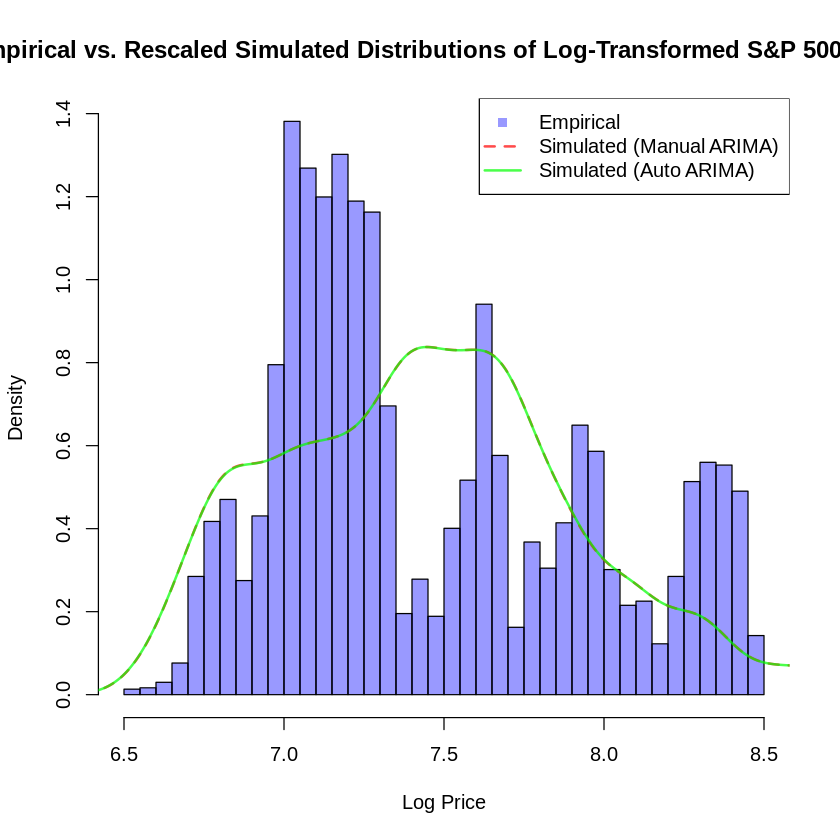

In [ ]:
# Set the number of simulations to match the original series length
n <- length(log_sp500_prices)

# Fit the manual ARIMA model and auto ARIMA model to use their parameters for simulations
fit_manual <- best_model  # Best model from manual fitting (ARIMA(0, 1, 1))
fit_auto <- auto_arima_model  # Auto ARIMA model selected by auto.arima()

# Simulate data based on the manually fitted ARIMA model parameters
set.seed(123)
sim_manual <- arima.sim(model = list(order = c(best_order[1], best_order[2], best_order[3]),
                                     ma = fit_manual$coef[grep("ma", names(fit_manual$coef))]),
                        n = n)

# Simulate data based on the auto-selected ARIMA model parameters
auto_order <- arimaorder(fit_auto)
set.seed(123)
sim_auto <- arima.sim(model = list(order = c(auto_order[1], auto_order[2], auto_order[3]),
                                   ar = fit_auto$coef[grep("ar", names(fit_auto$coef))],
                                   ma = fit_auto$coef[grep("ma", names(fit_auto$coef))]),
                      n = n)

# Rescale the simulated series to match the empirical distribution of log-transformed S&P 500 prices
sim_manual <- scale(sim_manual) * sd(log_sp500_prices) + mean(log_sp500_prices)
sim_auto <- scale(sim_auto) * sd(log_sp500_prices) + mean(log_sp500_prices)

# Plot empirical distribution with rescaled simulated distributions for comparison
hist(log_sp500_prices, breaks = 50, probability = TRUE, main = "Empirical vs. Rescaled Simulated Distributions of Log-Transformed S&P 500 Prices",
     xlab = "Log Price", col = rgb(0, 0, 1, 0.4), border = "black")
lines(density(sim_manual), col = rgb(1, 0, 0, 0.7), lwd = 2, lty = 2)  # Manual simulation in red dashed line
lines(density(sim_auto), col = rgb(0, 1, 0, 0.7), lwd = 2, lty = 1)   # Auto simulation in green solid line
legend("topright", legend = c("Empirical", "Simulated (Manual ARIMA)", "Simulated (Auto ARIMA)"),
       col = c(rgb(0, 0, 1, 0.4), rgb(1, 0, 0, 0.7), rgb(0, 1, 0, 0.7)), lty = c(NA, 2, 1), pch = c(15, NA, NA), lwd = 2)


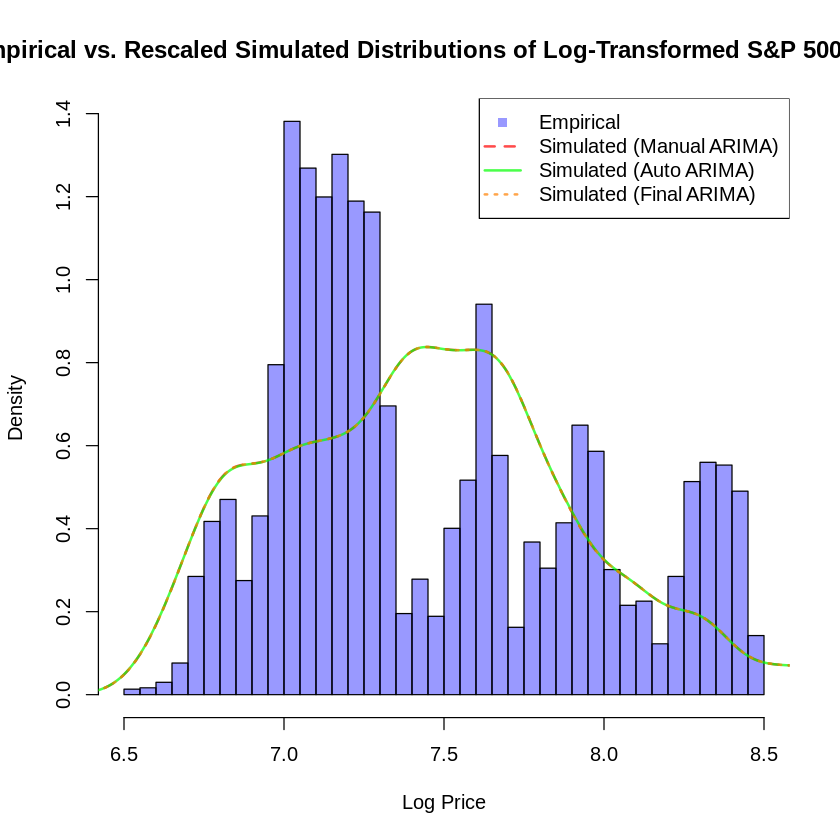

In [ ]:
# Set the number of simulations to match the original series length
n <- length(log_sp500_prices)

# Fit the manual ARIMA model, auto ARIMA model, and final chosen model to use their parameters for simulations
fit_manual <- best_model       # Best model from manual fitting (e.g., ARIMA(0, 1, 1))
fit_auto <- auto_arima_model   # Auto ARIMA model selected by auto.arima()
fit_final <- final_model       # Final chosen model (from manual or auto selection)

# Simulate data based on the manually fitted ARIMA model parameters
set.seed(123)
sim_manual <- arima.sim(model = list(order = c(best_order[1], best_order[2], best_order[3]),
                                     ma = fit_manual$coef[grep("ma", names(fit_manual$coef))]),
                        n = n)

# Simulate data based on the auto-selected ARIMA model parameters
auto_order <- arimaorder(fit_auto)
set.seed(123)
sim_auto <- arima.sim(model = list(order = c(auto_order[1], auto_order[2], auto_order[3]),
                                   ar = fit_auto$coef[grep("ar", names(fit_auto$coef))],
                                   ma = fit_auto$coef[grep("ma", names(fit_auto$coef))]),
                      n = n)

# Simulate data based on the final chosen ARIMA model parameters
final_order <- arimaorder(fit_final)
set.seed(123)
sim_final <- arima.sim(model = list(order = c(final_order[1], final_order[2], final_order[3]),
                                    ar = fit_final$coef[grep("ar", names(fit_final$coef))],
                                    ma = fit_final$coef[grep("ma", names(fit_final$coef))]),
                       n = n)

# Rescale the simulated series to match the empirical distribution of log-transformed S&P 500 prices
sim_manual <- scale(sim_manual) * sd(log_sp500_prices) + mean(log_sp500_prices)
sim_auto <- scale(sim_auto) * sd(log_sp500_prices) + mean(log_sp500_prices)
sim_final <- scale(sim_final) * sd(log_sp500_prices) + mean(log_sp500_prices)

# Plot empirical distribution with rescaled simulated distributions for comparison
hist(log_sp500_prices, breaks = 50, probability = TRUE,
     main = "Empirical vs. Rescaled Simulated Distributions of Log-Transformed S&P 500 Prices",
     xlab = "Log Price", col = rgb(0, 0, 1, 0.4), border = "black")
lines(density(sim_manual), col = rgb(1, 0, 0, 0.7), lwd = 2, lty = 2)  # Manual simulation in red dashed line
lines(density(sim_auto), col = rgb(0, 1, 0, 0.7), lwd = 2, lty = 1)    # Auto simulation in green solid line
lines(density(sim_final), col = rgb(1, 0.5, 0, 0.7), lwd = 2, lty = 3) # Final chosen simulation in orange dotted line

legend("topright", legend = c("Empirical", "Simulated (Manual ARIMA)", "Simulated (Auto ARIMA)", "Simulated (Final ARIMA)"),
       col = c(rgb(0, 0, 1, 0.4), rgb(1, 0, 0, 0.7), rgb(0, 1, 0, 0.7), rgb(1, 0.5, 0, 0.7)),
       lty = c(NA, 2, 1, 3), pch = c(15, NA, NA, NA), lwd = 2)
